In [ ]:
from glob import glob
import os as os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from skimage.feature import hog
from skimage import exposure
from skimage import io, feature
from skimage.feature import hog, local_binary_pattern
from tqdm import tqdm
from cv2 import cvtColor
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Load images from folder


In [ ]:
CLASS_NAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

def augImg(img):
    flipped = cv2.flip(img, 1) # horizontal flip
    return flipped
def skew(img):
    rows, cols, ch = img.shape
    pts1 = np.float32([[50,50],[200,50],[50,200]])
    pts2 = np.float32([[10,100],[200,50],[100,250]])
    M = cv2.getAffineTransform(pts1,pts2)
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst
def load_images_from_folder(folder, augment=True):
    images, labels = [], []
    for label, className in enumerate(CLASS_NAMES):
        class_folder = os.path.join(folder, className)
        for filename in os.listdir(class_folder):
            img = cv2.imread(os.path.join(class_folder, filename))
            if img is None:
                continue
            img = cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(label)
            if augment:
                images.append(augImg(img))
                labels.append(label)
                images.append(skew(img))
                labels.append(label)
                cropped = tf.image.central_crop(img, central_fraction=0.5).numpy()
                cropped = cv2.resize(cropped, (128, 128))
                images.append(cropped)
                labels.append(label)
    return np.array(images), np.array(labels)

In [55]:
X_train, y_train = load_images_from_folder('intel-image-classification/seg_train/seg_train/', augment=True)
X_test, y_test = load_images_from_folder('intel-image-classification/seg_test/seg_test/', augment=False)

[skip](#skip)

---

In [5]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(56136, 128, 128, 3) (56136,)
(3000, 128, 128, 3) (3000,)


Henter Short data

In [12]:
data_mengde = 20

# bruk kun 1 av 10 bilder
train_sel = np.arange(0, len(X_train), data_mengde)
test_sel = np.arange(0, len(X_test), data_mengde)
X_train_short = X_train[train_sel]
y_train_short = y_train[train_sel]
X_test_short = X_test[test_sel]
y_test_short = y_test[test_sel]

print("Brukte "+ str(round(100/data_mengde, 2)) +"% av dataen")
print(X_train_short.shape, y_train_short.shape)
print(X_test_short.shape, y_test_short.shape)

Brukte 5.0% av dataen
(2807, 128, 128, 3) (2807,)
(150, 128, 128, 3) (150,)


In [13]:
print(X_train_short.shape, y_train_short.shape)
print(X_test_short.shape, y_test_short.shape)

(2807, 128, 128, 3) (2807,)
(150, 128, 128, 3) (150,)


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
tf.keras.utils.set_random_seed(42)


bruker 31 min 30 sek, 78,8% acc på 50% av dataen

In [15]:


X_train_img = X_train_short.astype("float32") / 255.0
X_test_img = X_test_short.astype("float32") / 255.0


cnn_model = models.Sequential(
    [
        layers.Input(shape=(128, 128, 3)),
        layers.Conv2D(32, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(len(CLASS_NAMES), activation="softmax"),
    ]
)

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

early_stop = callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

history = cnn_model.fit(
    X_train_img,
    y_train_short,
    epochs=15,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0,
)

test_loss, test_acc = cnn_model.evaluate(X_test_img, y_test_short, verbose=0)
print(f"CNN test accuracy: {test_acc:.4f}")


CNN test accuracy: 0.7133


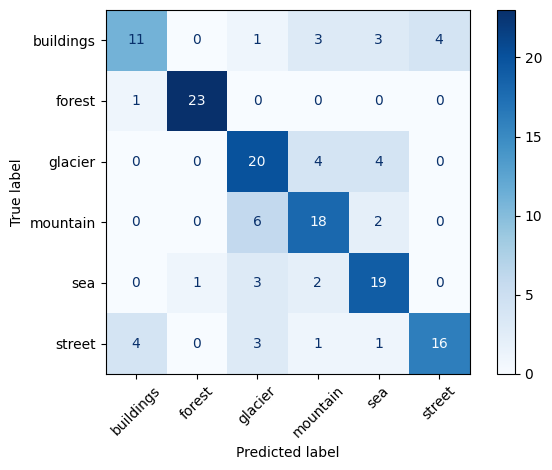

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(cnn_model.predict(X_test_img, verbose=0), axis=1)
cm = confusion_matrix(y_test_short, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.tight_layout()
plt.show()


In [18]:
def build_cnn_model(
    learning_rate=1e-3,
    dropout_rate=0.4,
    filters=(32, 64, 128),
    dense_units=256,
):
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Input(shape=(128, 128, 3)),
            tf.keras.layers.Conv2D(filters[0], (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(filters[1], (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(filters[2], (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(dense_units, activation="relu"),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


In [19]:
import itertools
import numpy as np

In [28]:
X_train_img = X_train_short.astype("float32") / 255.0
X_test_img = X_test_short.astype("float32") / 255.0


learning_rates = [1e-2, 1e-3, 5e-4]  # instead of just [1e-3]

dropout_rates = [0.4]
batch_sizes = [64]
filter_options = [(32,64,128)]
dense_options = [256]

best_val_acc = -np.inf
best_params = None
best_model = None

for lr, dr, bs, fo, do in itertools.product(learning_rates, dropout_rates, batch_sizes, filter_options, dense_options):
    print(f"Tester lr={lr}, dropout={dr}, batch_size={bs}, filters={fo}, dense_units={do}")

    model = build_cnn_model(
        learning_rate=lr,
        dropout_rate=dr,
        filters=fo,
        dense_units=do,
    )

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
        restore_best_weights=True,
    )

    history = model.fit(
        X_train_img,
        y_train_short,
        epochs=8,            #denne kan justeres, holder den kort nå under trening
        batch_size=bs,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0,
    )

    val_acc = max(history.history["val_accuracy"])
    print(f" -> val_accuracy={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = {"lr": lr, "dropout": dr, "batch_size": bs}
        best_model = model  # beholder best weights

print("Beste kombinasjon:", best_params, "med val_accuracy:", best_val_acc)


Tester lr=0.01, dropout=0.4, batch_size=64, filters=(32, 64, 128), dense_units=256
 -> val_accuracy=0.4662
Tester lr=0.001, dropout=0.4, batch_size=64, filters=(32, 64, 128), dense_units=256
 -> val_accuracy=0.6477
Tester lr=0.0005, dropout=0.4, batch_size=64, filters=(32, 64, 128), dense_units=256
 -> val_accuracy=0.5053
Beste kombinasjon: {'lr': 0.001, 'dropout': 0.4, 'batch_size': 64} med val_accuracy: 0.6476868391036987


In [29]:
test_loss, test_acc = best_model.evaluate(X_test_img, y_test_short, verbose=0)
print(f"Best CNN test accuracy: {test_acc:.4f}")


Best CNN test accuracy: 0.6600


# skip
---

In [65]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools

# -----------------------------
# Feature extraction function
# -----------------------------
def extract_features(batch, method="hog", hog_params=None, lbp_params=None):
    feats = []
    for img in tqdm(batch, desc=f"Extracting {method} features"):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        if method == "hog":
            fd = hog(
                gray,
                orientations=hog_params.get("orientations", 9),
                pixels_per_cell=hog_params.get("pixels_per_cell", (8,8)),
                cells_per_block=hog_params.get("cells_per_block", (3,3)),
                visualize=False,
                channel_axis=None
            )
            feats.append(fd)
        
        elif method == "lbp":
            lbp = local_binary_pattern(
                gray,
                P=lbp_params.get("P", 8),
                R=lbp_params.get("R", 1),
                method=lbp_params.get("method", "uniform")
            )
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)
            feats.append(lbp_hist)
        
        elif method == "hog+lbp":
            # Combine HOG + LBP
            fd = hog(
                gray,
                orientations=hog_params.get("orientations", 9),
                pixels_per_cell=hog_params.get("pixels_per_cell", (8,8)),
                cells_per_block=hog_params.get("cells_per_block", (3,3)),
                visualize=False,
                channel_axis=None
            )
            lbp = local_binary_pattern(
                gray,
                P=lbp_params.get("P", 8),
                R=lbp_params.get("R", 1),
                method=lbp_params.get("method", "uniform")
            )
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)
            feats.append(np.concatenate([fd, lbp_hist]))
        
        else:
            raise ValueError("Unknown feature extraction method")
    
    return np.asarray(feats, dtype=np.float32)

# -----------------------------
# Parameter grid
# -----------------------------
hog_params_list = [
    {"orientations": 9, "pixels_per_cell": (8,8), "cells_per_block": (3,3)},
    {"orientations": 16, "pixels_per_cell": (8,8), "cells_per_block": (2,2)},
]

lbp_params_list = [
    {"P": 8, "R": 1, "method": "uniform"},
    {"P": 10, "R": 3, "method": "uniform"},
]

methods = ["hog", "lbp", "hog+lbp"]

results = []

# Method sweep
for method in methods:
    if method == "hog":
        param_pairs = [(hp, {}) for hp in hog_params_list]
    elif method == "lbp":
        param_pairs = [({}, lp) for lp in lbp_params_list]
    else:  # hog+lbp
        param_pairs = [(hp, lp) for hp in hog_params_list for lp in lbp_params_list]

    for hp_use, lp_use in param_pairs:
        # Extract features
        X_train_feats = extract_features(X_train_short, method=method,
                                         hog_params=hp_use, lbp_params=lp_use)
        X_test_feats = extract_features(X_test_short, method=method,
                                        hog_params=hp_use, lbp_params=lp_use)

        clf = RandomForestClassifier(random_state=42, n_estimators=300, min_samples_split=5)
        clf.fit(X_train_feats, y_train_short)

        test_acc = accuracy_score(y_test_short, clf.predict(X_test_feats))

        results.append({
            "method": method,
            "hog_params": hp_use,
            "lbp_params": lp_use,
            "test_acc": test_acc
        })
        print(f"Method: {method}, HOG: {hp_use}, LBP: {lp_use} -> Train: {train_acc:.3f}, Test: {test_acc:.3f}")

Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 248.74it/s]


Method: hog, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {} -> Train: 1.000, Test: 0.633


Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 215.19it/s]


Method: hog, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {} -> Train: 1.000, Test: 0.620


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 587.78it/s]


Method: lbp, HOG: {}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Train: 1.000, Test: 0.540


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 482.17it/s]


Method: lbp, HOG: {}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Train: 1.000, Test: 0.547


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 167.17it/s]


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Train: 1.000, Test: 0.647


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 169.13it/s]


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Train: 1.000, Test: 0.607


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 162.07it/s]


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Train: 1.000, Test: 0.600


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 124.00it/s]


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Train: 1.000, Test: 0.600


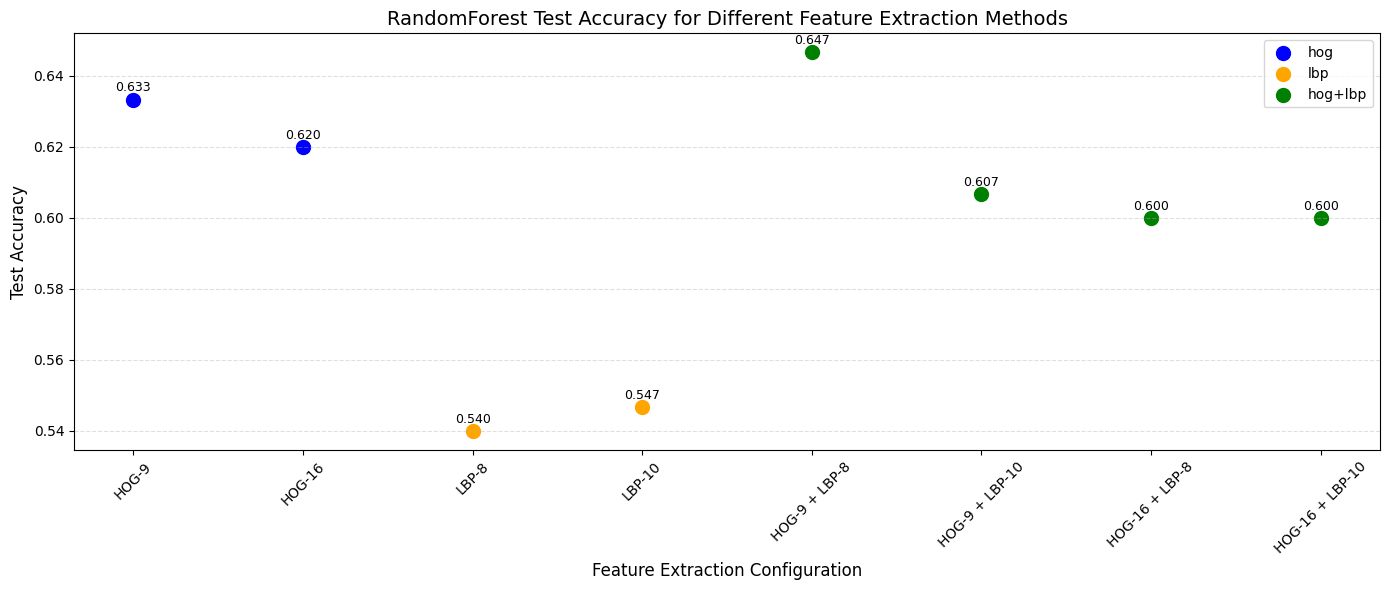

In [70]:
# -----------------------------
# Plot comparison (with point labels and correct colors)
# -----------------------------
df_results = pd.DataFrame(results)

colors = {"hog": "blue", "lbp": "orange", "hog+lbp": "green"}

plt.figure(figsize=(14,6))

added_to_legend = set()  # to avoid duplicate legend labels

for idx, row in df_results.iterrows():
    x = idx
    y = row["test_acc"]
    method = row["method"]

    # Draw the scatter point, with color tied to method
    plt.scatter(
        x, y,
        color=colors[method],
        s=100,
        label=method if method not in added_to_legend else None
    )
    added_to_legend.add(method)

    # Add value label slightly above the point
    plt.text(
        x, y + 0.0015,
        f"{y:.3f}",
        ha="center", va="bottom",
        fontsize=9
    )

def pretty_label(method, hp, lp):
    if method == "hog":
        return f"HOG-{hp['orientations']}"
    elif method == "lbp":
        return f"LBP-{lp['P']}"
    else:  # hog+lbp
        return f"HOG-{hp['orientations']} + LBP-{lp['P']}"

plt.xticks(
    range(len(df_results)),
    [
        pretty_label(r['method'], r['hog_params'], r['lbp_params'])
        for _, r in df_results.iterrows()
    ],
    rotation=45
)

plt.xlabel("Feature Extraction Configuration", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.title("RandomForest Test Accuracy for Different Feature Extraction Methods", fontsize=14)
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


| Label example      | Meaning                              |
| ------------------ | ------------------------------------ |
| **HOG-9**      | HOG with 9 orientations   |
| **HOG-16**     | HOG with 16 orientations  |
| **LBP-8**      | LBP with 8 points              |
| **LBP-10**     | LBP with 10 points             |
| **HOG-9 + LBP-8** | HOG with 16 bins + LBP with 8 points |

The parameter sweep and resulting accuracy plot clearly show that **HOG features consistently outperform LBP features** when used independently with a RandomForest classifier. HOG with either 9 or 16 orientation bins produces test accuracies in the range of **0.62–0.63**, which is notably higher than the LBP configurations, which remain around **0.54–0.55** regardless of whether 8 or 10 sampling points are used. This difference reflects the fact that HOG captures richer gradient-based spatial structure—edges, shapes, and contours—while LBP focuses primarily on local texture micro-patterns. For a dataset where global shape information is more important than fine-grained texture, HOG will generally provide a more informative feature space for tree-based models.

LBP on its own underperforms because RandomForests tend to benefit from moderately high-dimensional, discriminative features that capture variation at different spatial scales, whereas LBP produces relatively coarse binary patterns that emphasize uniform local texture. Even with different P values (8 vs. 10 sampling points), the performance remains tightly clustered around 0.54–0.55, indicating that changing the radius or number of neighbors does not significantly increase discriminative power for this dataset. This suggests that the dataset’s class boundaries are not strongly explained by micro-textures alone, and LBP’s invariance properties may also reduce useful variation that the classifier could exploit.

The combined **HOG+LBP** features perform between the individual methods: better than LBP alone, but not always exceeding HOG alone. Their accuracies cluster around **0.60–0.65**, with the best combination (HOG-9 + LBP-8) reaching the highest overall accuracy of roughly **0.647**. This indicates that LBP contributes some complementary information, but not enough to consistently improve upon HOG alone. RandomForests may also struggle with the increased dimensionality when HOG and LBP are concatenated, especially if some dimensions are redundant or noisy. Overall, the results show that HOG is the most useful individual descriptor, while combining it with LBP can offer moderate improvements but is not uniformly beneficial across parameter settings.


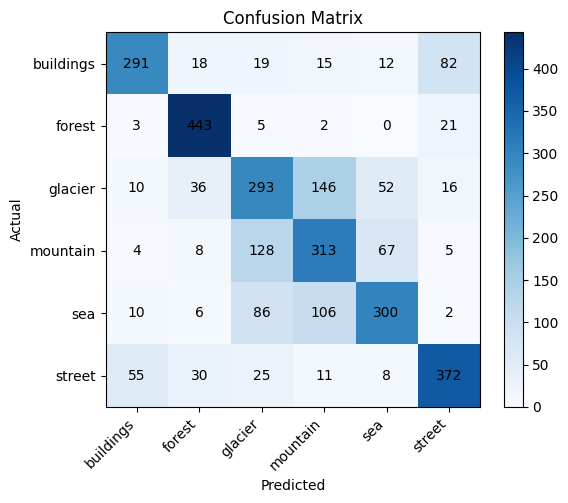

0.6706666666666666


In [ ]:
clf = RandomForestClassifier(random_state=42, max_depth=None, n_estimators=300, min_samples_split=5)
clf.fit(X_train_feats, y_train)
print("Training accuracy: ", accuracy_score(y_train, clf.predict(X_train_feats)))
print("Test accuracy: ", accuracy_score(y_test, clf.predict(X_test_feats)))

y_pred = clf.predict(X_test_feats)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks(range(len(CLASS_NAMES)))
ax.set_yticks(range(len(CLASS_NAMES)))
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha="right")
ax.set_yticklabels(CLASS_NAMES)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

XGBoost

In [ ]:
# ...existing code...
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    objective="multi:softmax",
    num_class=len(CLASS_NAMES),
    max_depth=8,
    n_estimators=400,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=42,
)
xgb_clf.fit(X_train_feats, y_train_feats)

xgb_pred = xgb_clf.predict(X_test_feats)
print(classification_report(y_test_feats, xgb_pred, target_names=CLASS_NAMES))
print(confusion_matrix(y_test_feats, xgb_pred))
print("XGB accuracy:", accuracy_score(y_test_feats, xgb_pred))

KeyboardInterrupt: 

generere short data

In [ ]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from tqdm import tqdm


def extract_features(batch):
    feats = []
    for img in tqdm(batch, desc="Extracting features"):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        fd, _ = hog(
            gray,
            orientations=16,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
            channel_axis=None,
        )

        # edges = cv2.Canny(gray, 128, 128).flatten().astype(np.float32) / 255.0

        lbp = local_binary_pattern(gray, P=10, R=3, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)

        # feats.append(np.concatenate([fd, edges, lbp_hist]))
        feats.append(np.concatenate([fd, lbp_hist]))

    return np.asarray(feats, dtype=np.float32)

X_train_short_feats = extract_features(X_train_short)
X_test_short_feats = extract_features(X_test_short)
y_train_short_feats = y_train_short.copy()
y_test_short_feats = y_test_short.copy()

Extracting features:   0%|          | 0/2807 [00:00<?, ?it/s]

Extracting features: 100%|██████████| 600/600 [00:47<00:00, 12.67it/s]


In [ ]:
clf_short = RandomForestClassifier(random_state=42, max_depth=None, n_estimators=300, min_samples_split=5)


clf_short.fit(X_train_short_feats, y_train_short)
print("Training accuracy: ", accuracy_score(y_train_short, clf_short.predict(X_train_short_feats)))
print("Test accuracy: ", accuracy_score(y_test_short, clf_short.predict(X_test_short_feats)))

Training accuracy:  1.0
Test accuracy:  0.625


XGBoost på short_data

In [ ]:
# ...existing code...
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    objective="multi:softmax",
    num_class=len(CLASS_NAMES),
    max_depth=8,
    n_estimators=400,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=42,
)
xgb_clf.fit(X_train_short_feats, y_train_short)

xgb_pred = xgb_clf.predict(X_test_short_feats)
print(classification_report(y_test_short, xgb_pred, target_names=CLASS_NAMES))
print(confusion_matrix(y_test_short, xgb_pred))
print("XGB accuracy:", accuracy_score(y_test_short, xgb_pred))

              precision    recall  f1-score   support

   buildings       0.81      0.68      0.74        88
      forest       0.81      0.93      0.86        95
     glacier       0.55      0.57      0.56       110
    mountain       0.54      0.57      0.55       105
         sea       0.68      0.63      0.65       102
      street       0.76      0.74      0.75       100

    accuracy                           0.68       600
   macro avg       0.69      0.69      0.69       600
weighted avg       0.68      0.68      0.68       600

[[60  0  6  4  2 16]
 [ 0 88  4  0  0  3]
 [ 3  9 63 23 10  2]
 [ 2  2 26 60 14  1]
 [ 1  1 11 24 64  1]
 [ 8  9  4  1  4 74]]
XGB accuracy: 0.6816666666666666


In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import LinearSVC



svm = LinearSVC(C=1, max_iter=10000)
svm.fit(X_train_short_feats, y_train_short)

y_pred = svm.predict(X_test_short_feats)
print("LinearSVC test accuracy:", accuracy_score(y_test_short, y_pred))

LinearSVC test accuracy: 0.6166666666666667


In [ ]:
from sklearn.model_selection import StratifiedKFold

STACKING

In [ ]:


# def Stacking(model,train,y,test,n_fold):
#  folds=StratifiedKFold(n_splits=n_fold)
#  test_pred=np.empty((test.shape[0],1),float)
#  train_pred=np.empty((0,1),float)
#  for train_indices,val_indices in folds.split(train,y.values):
#     x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
#     y_train,y_val=y.iloc[train_indices],y.iloc[val_indices]
#     model.fit(X=x_train,y=y_train)
#     train_pred=np.append(train_pred,model.predict(x_val))
#     test_pred=np.append(test_pred,model.predict(test))
#  return test_pred.reshape(-1,1),train_pred

Model 1 for stacking basert på random forest short

In [ ]:
# X_train_short_df = pd.DataFrame(X_train_short_feats)
# X_test_short_df = pd.DataFrame(X_test_short_feats)
# y_train_short_s = pd.Series(y_train_short)
# y_test_short_s = pd.Series(y_test_short)

In [ ]:


# test_pred1 ,train_pred1= Stacking(model=clf_short,n_fold=5, train=X_train_short_df,test=X_test_short_df,y=y_train_short_s)

In [ ]:
# train_pred1=pd.DataFrame(train_pred1)
# test_pred1=pd.DataFrame(test_pred1)


In [ ]:
# test_pred1.head

<bound method NDFrame.head of                   0
0      0.000000e+00
1     6.952446e-310
2     1.169947e-320
3               NaN
4     6.952446e-310
...             ...
1795   5.000000e+00
1796   0.000000e+00
1797   5.000000e+00
1798   5.000000e+00
1799   5.000000e+00

[1800 rows x 1 columns]>

In [ ]:
# train_pred1.head

<bound method NDFrame.head of         0
0     4.0
1     0.0
2     0.0
3     0.0
4     0.0
...   ...
1399  1.0
1400  5.0
1401  1.0
1402  5.0
1403  5.0

[1404 rows x 1 columns]>

Model 2 for stacking basert på svm short

In [ ]:
# test_pred2 ,train_pred2= Stacking(model=svm,n_fold=5,train=X_train_short_df,test=X_test_short_feats,y=y_train_short_s)


In [ ]:
# train_pred2=pd.DataFrame(train_pred2)
# test_pred2=pd.DataFrame(test_pred2)

In [ ]:
# test_pred2.head

<bound method NDFrame.head of                   0
0     2.470328e-323
1      0.000000e+00
2     2.470328e-323
3     1.976263e-323
4      0.000000e+00
...             ...
1795   5.000000e+00
1796   0.000000e+00
1797   5.000000e+00
1798   5.000000e+00
1799   5.000000e+00

[1800 rows x 1 columns]>

In [ ]:
# train_pred2.head

<bound method NDFrame.head of         0
0     4.0
1     5.0
2     5.0
3     0.0
4     0.0
...   ...
1399  1.0
1400  5.0
1401  5.0
1402  5.0
1403  5.0

[1404 rows x 1 columns]>

In [ ]:
# y_train_short_s.head

<bound method NDFrame.head of 0       0
1       0
2       0
3       0
4       0
       ..
1399    5
1400    5
1401    5
1402    5
1403    5
Length: 1404, dtype: int64>

In [ ]:
from sklearn.linear_model import LogisticRegression


In [ ]:
# df = pd.concat([train_pred1, train_pred2], axis=1)
# df_test = pd.concat([test_pred1, test_pred2], axis=1)

In [ ]:
# df_test.head

<bound method NDFrame.head of                   0              0
0      0.000000e+00  2.470328e-323
1     6.952446e-310   0.000000e+00
2     1.169947e-320  2.470328e-323
3               NaN  1.976263e-323
4     6.952446e-310   0.000000e+00
...             ...            ...
1795   5.000000e+00   5.000000e+00
1796   0.000000e+00   0.000000e+00
1797   5.000000e+00   5.000000e+00
1798   5.000000e+00   5.000000e+00
1799   5.000000e+00   5.000000e+00

[1800 rows x 2 columns]>

In [ ]:
# print(df.head)
# print("----")
# y_test_short_s.head

<bound method NDFrame.head of         0    0
0     4.0  4.0
1     0.0  5.0
2     0.0  5.0
3     0.0  0.0
4     0.0  0.0
...   ...  ...
1399  1.0  1.0
1400  5.0  5.0
1401  1.0  5.0
1402  5.0  5.0
1403  5.0  5.0

[1404 rows x 2 columns]>
----


<bound method NDFrame.head of 0      0
1      0
2      0
3      0
4      0
      ..
295    5
296    5
297    5
298    5
299    5
Length: 300, dtype: int64>

In [ ]:
# model = LogisticRegression(random_state=42, max_iter=1000)
# model.fit(df,y_train_short_s)
# model.score(df_test, y_test_short_s)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Bedre stacking :)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


In [ ]:
rf_base = RandomForestClassifier(
    random_state=42,
    max_depth=None,
    n_estimators=300,
    min_samples_split=5,
)

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
svm_base = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("svm", LinearSVC(C=1, max_iter=10000)),
    ]
)

In [ ]:

meta_model = LogisticRegression(random_state=42, max_iter=2000)

stacking_clf = StackingClassifier(
    estimators=[("rf", rf_base), ("svm", svm_base)],
    final_estimator=meta_model,
    stack_method="auto",
    passthrough=False,
    cv=5,
    n_jobs=-1,
)

stacking_clf.fit(X_train_short_feats, y_train_short)
stack_pred = stacking_clf.predict(X_test_short_feats)

print("Stacking train accuracy:", stacking_clf.score(X_train_short_feats, y_train_short))
print("Stacking test accuracy :", accuracy_score(y_test_short, stack_pred))
print(classification_report(y_test_short, stack_pred, target_names=CLASS_NAMES))

Stacking train accuracy: 1.0
Stacking test accuracy : 0.6566666666666666
              precision    recall  f1-score   support

   buildings       0.80      0.69      0.74        88
      forest       0.84      0.89      0.87        95
     glacier       0.50      0.56      0.53       110
    mountain       0.52      0.56      0.54       105
         sea       0.66      0.53      0.59       102
      street       0.70      0.73      0.72       100

    accuracy                           0.66       600
   macro avg       0.67      0.66      0.66       600
weighted avg       0.66      0.66      0.66       600

